In [1]:
%load_ext autoreload

import os
import sys
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_object_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

root_dir = os.path.abspath('..')
sys.path.append(os.path.join(root_dir, 'src/'))

import feature_preprocess
import eda_functions

In [2]:
DATA_FOLDER = os.path.join(root_dir, 'data/')
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
SEGMENTS_FILE = 'Segments.xlsx'
RANDOM_STATE = 27

# Загрузка данных

In [3]:
segments = pd.read_excel(os.path.join(DATA_FOLDER, SEGMENTS_FILE))
display(segments)

,Номер сегмента,Возраст,Пол,Интересы
0,1,"25-34,35-41",Ж,-
1,2,"25-34,35-42",М,Пиво
2,3,"25-34,35-43",Ж,Дети
3,4,"18-24,25-34,35-44","М, Ж",Животные
4,5,"18-24,25-34,35-45","М, Ж",-


In [4]:
train_raw = pd.read_csv(os.path.join(DATA_FOLDER, TRAIN_FILE))
display(train_raw)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1
...,...,...,...,...,...,...,...,...,...,...
44854511,3,Games,Simulation,1068204657,2021-08-07 17:19:23,MSK,Краснодарский край,Краснодар,ios,14.4.2
44854512,3,Games,Puzzle,com.easybrain.nonogram.color,2021-08-02 09:17:16,MSK,Владимирская область,Владимир,android,11.0
44854513,5,Games,Arcade,com.nordcurrent.canteenhd,2021-09-16 09:26:38,MSK,Брянская область,Брянск,android,5.1
44854514,4,NaN,NaN,com.fugo.wow,2021-07-09 18:02:33,MSK,Татарстан,Казань,Android,7.1.2


In [5]:
test_raw = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
display(test_raw)

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,Applications,Shopping,com.allgoritm.youla,2021-09-19 17:31:33,MSK+2,Свердловская область,Екатеринбург,android,10.0
1,NaN,NaN,com.ChocochocoStd.RapBattle,2021-08-03 17:13:17,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10.0
2,NaN,NaN,1387897651,2021-09-17 15:54:00,MSK,Москва,Москва,ios,14.4.0
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,2021-07-05 23:34:59,MSK,Краснодарский край,Краснодар,android,9.0.0
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 15:15:21,MSK,Татарстан,Набережные Челны,android,10.0
...,...,...,...,...,...,...,...,...,...
11213624,NaN,NaN,com.phonemaster.jewelhunter,2021-08-04 05:55:26,MSK,Санкт-Петербург,Санкт-Петербург,android,8.1.0
11213625,NaN,NaN,com.linkdesks.jewellegend,2021-09-17 21:45:02,MSK,Ставрополье,Пятигорск,android,10
11213626,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 10:24:31,MSK+6,Забайкальский Край,Чита,android,11.0
11213627,NaN,NaN,com.onebutton.mrsuper,2021-07-05 16:02:47,MSK+2,Башкортостан,Белорецк,android,6.0.1


In [6]:
def prepare_X_y(data, target, prefix='Segment', drop_duplicates=False):
    data = data.copy()

    if drop_duplicates:
        data.drop_duplicates(inplace=True)
    
    targets_df = pd.get_dummies(data[target], prefix=prefix)

    X = data.drop(columns=target)
    y_list = []
    for col in targets_df.columns:
        y_list.append(targets_df[col])

    return X, y_list

In [7]:
def train_model(pars, X_train, y_train, X_val, y_val, eval_metric):

    model = lightgbm.LGBMClassifier(**pars)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=(X_val, y_val))

    return model

def validate_model(model, X_train, y_train, X_val, y_val):

    print('model')
    print('Train roc auc', metrics.roc_auc_score(y_train, model.predict_proba(X_train).T[1]))
    print('Validation roc auc', metrics.roc_auc_score(y_val, model.predict_proba(X_val).T[1]))

    print(metrics.classification_report(y_val, model.predict(X_val)))

    eda_functions.plot_confusion_matrix(y_val, model.predict(X_val))

In [13]:
def check_roc_auc(y_true, y_pred_proba):
    for true, pred_proba in zip(y_true, y_pred_proba):
        print(true.name)
        print(metrics.roc_auc_score(true, pred_proba))

# Подготовка датасета

In [8]:
train,  valid_test = train_test_split(train_raw, test_size=0.3, random_state=RANDOM_STATE, stratify=train_raw['Segment'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=valid_test['Segment'])

In [9]:
X_train, y_train = prepare_X_y(train, 'Segment', prefix='Segment', drop_duplicates=True)
X_valid, y_valid = prepare_X_y(valid, 'Segment', prefix='Segment', drop_duplicates=False)
X_test, y_test = prepare_X_y(test, 'Segment', prefix='Segment', drop_duplicates=False)

train
5    12031254
3     9930938
4     7799456
2      991371
1      645142
Name: Segment, dtype: int64


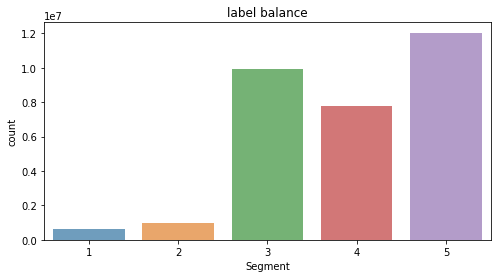

validation
5    2578126
3    2128058
4    1671312
2     212437
1     138244
Name: Segment, dtype: int64


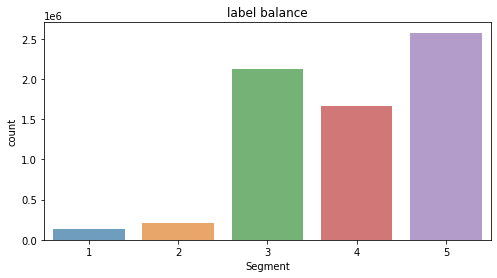

test
5    2578126
3    2128058
4    1671312
2     212437
1     138245
Name: Segment, dtype: int64


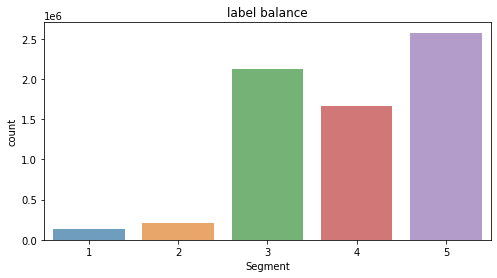

In [10]:
for d, name in zip([train, valid, test], ['train', 'validation', 'test']):
    print(name)
    eda_functions.show_label_balance(d, label='Segment')

# Обучение моделей

In [11]:
print([y.name for y in y_train])

['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']


In [12]:
pars = {}
models = {}
eval_metric='auc'

In [ ]:
key = y_train.name[0]

pars[key] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 10,
}

models[key] = train_model(pars, X_train, y_train[key], X_valid, y_valid[key], eval_metric)
validate_model(models[key], X_train, y_train[key], X_valid, y_valid[key])